# Readouts after a previous randomization

We've seen that randomization of lower layers has no effect on the final readout from a network, even though label information is in the CLS token. How quickly does information get read into the CLS tokens? Can I randomize and then get a novel readout from the next layer?

Uses model: `google/vit-base-patch16-224`, dataset: `zh-plus/tiny-imagenet`

__Important Notes:__
- this run doesn't have a randomization-free baseline due a bug in that last run
- the decoders are trained on post-randomization data: this experiment tests how quickly label information is _read back into_ the CLS tokens after randomization.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm

In [3]:
all_data = []
for layer_ind in range(12):
    all_data.append(pd.read_csv(f'randomized_probe_acc/intermediate_vit.encoder.layer.{layer_ind}.csv'))

In [6]:
all_data = pd.concat(all_data).drop(columns='Unnamed: 0')

In [11]:
print((all_data['test'] == 'layerwise_probe').all())
all_data = all_data.drop(columns='test')

True


In [12]:
all_data

,probed_layer,accuracy,randomized_layer
0,vit.encoder.layer.0,0.0057,vit.encoder.layer.0
1,vit.encoder.layer.1,0.2216,vit.encoder.layer.0
2,vit.encoder.layer.2,0.3204,vit.encoder.layer.0
3,vit.encoder.layer.3,0.3894,vit.encoder.layer.0
4,vit.encoder.layer.4,0.4485,vit.encoder.layer.0
...,...,...,...
7,vit.encoder.layer.7,0.6030,vit.encoder.layer.11
8,vit.encoder.layer.8,0.6603,vit.encoder.layer.11
9,vit.encoder.layer.9,0.7150,vit.encoder.layer.11
10,vit.encoder.layer.10,0.8004,vit.encoder.layer.11


/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


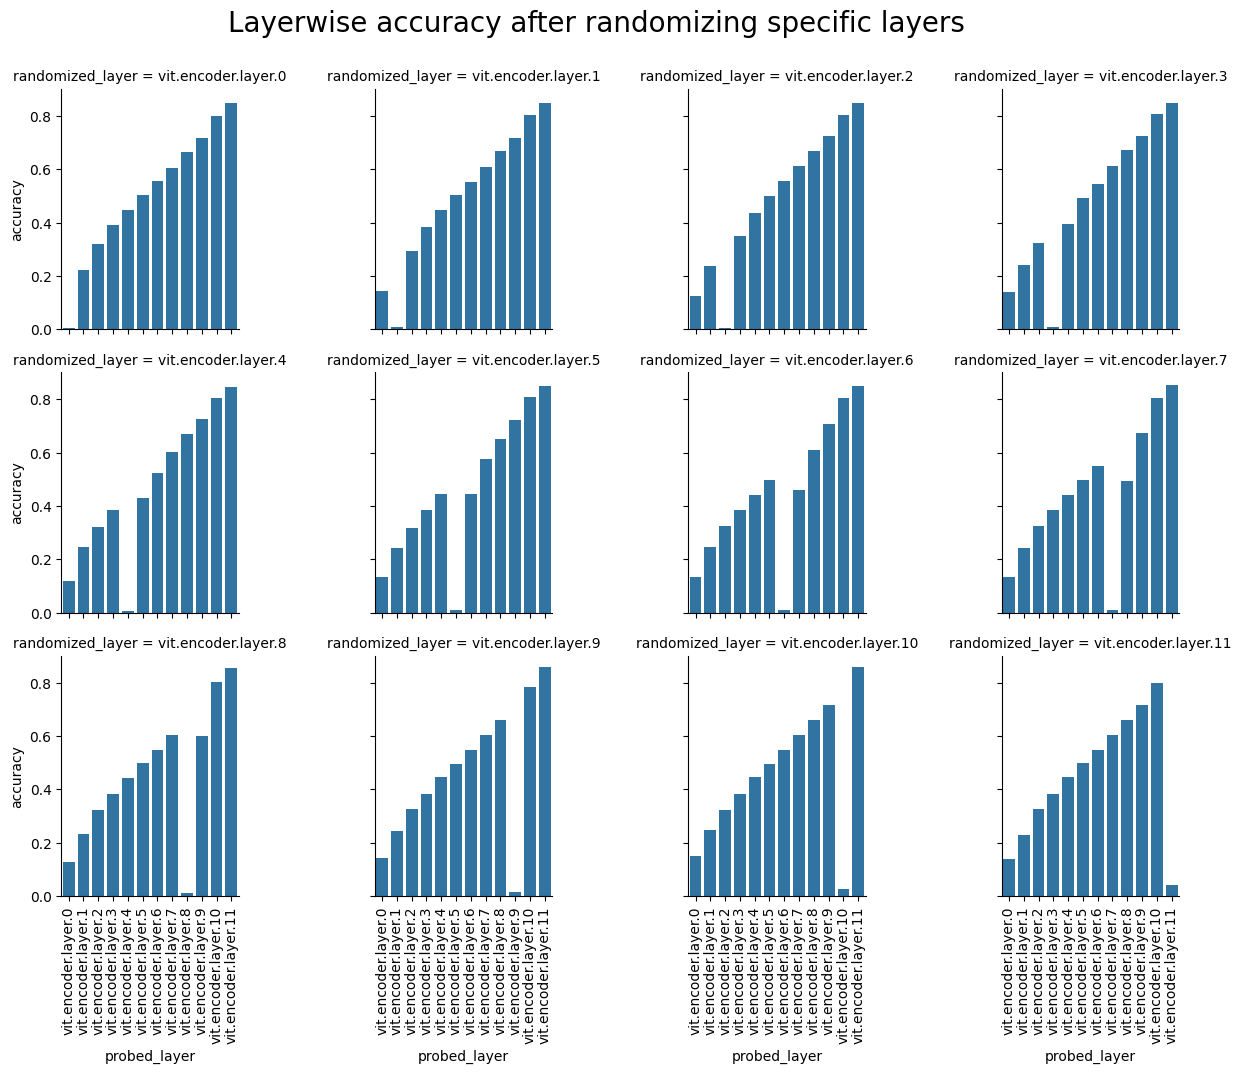

In [28]:
g = sns.FacetGrid(all_data, col="randomized_layer", col_wrap=4)
g.map(sns.barplot, "probed_layer", "accuracy", alpha=1)
g.add_legend()
_=[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
_=plt.suptitle('Layerwise accuracy after randomizing specific layers',  y=1.05, fontsize=20)

This is, for the most part, exactly what I would have hoped to see. Randomization kills the accuracy in the layers that are randomized, but the network recovers quickly to the previous accuracy, meaning that we can extract multiple answers from the network.

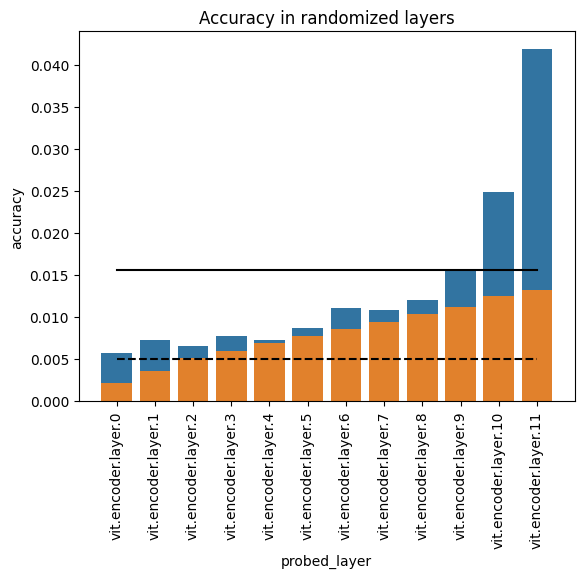

In [87]:
plt.title('Accuracy in randomized layers')

#take as a baseline the accuracy before randomization x shuffle probability
# 
shuffle_prob = 1.* 1./64
baselines = all_data[all_data['randomized_layer'] == 'vit.encoder.layer.11']
last_layer_baseline = all_data[(all_data['randomized_layer'] == 'vit.encoder.layer.0')
                              & (all_data['probed_layer'] == 'vit.encoder.layer.11')]

baselines = pd.concat([baselines[ baselines['probed_layer'] != 'vit.encoder.layer.11'],
                      last_layer_baseline])
baselines['accuracy'] *= shuffle_prob


sns.barplot(all_data[all_data['probed_layer'] == all_data['randomized_layer']], x="probed_layer", y="accuracy")
sns.barplot(baselines, x="probed_layer", y="accuracy")
plt.plot(baselines['probed_layer'], 12*[1/200], '--k')
plt.plot(baselines['probed_layer'], 12*[1/64], '-k')
_=plt.xticks(rotation=90)


Randomized layers perform similarly to expected. There is some over-performance across all layers, but particularly in the last layers of the model, which is surprising.

These models exceed both picking a single output at for all decodings (lower black line), and the frequency of shuffle matches, ignoring multiple samples (upper black line). Even accounting for multiple samples and adding in the single out strategy gives ~0.028 as a baseline, so the last layer decoding accuracy is certainly higher than expected.

I'm not sure how to account for this at the moment, but it's worth adding a note of caution. Ideas:
- 'batch leakage': using some batch level features due to batch-level normalization.
- cross attention in the transformer layers?
- shared train-test datapoints in this dataset?

Future steps:
1. Global activity distribution, either by recording or fitting on the train CLS distribution.


/Users/luke/.local/defaultPythonEnv/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


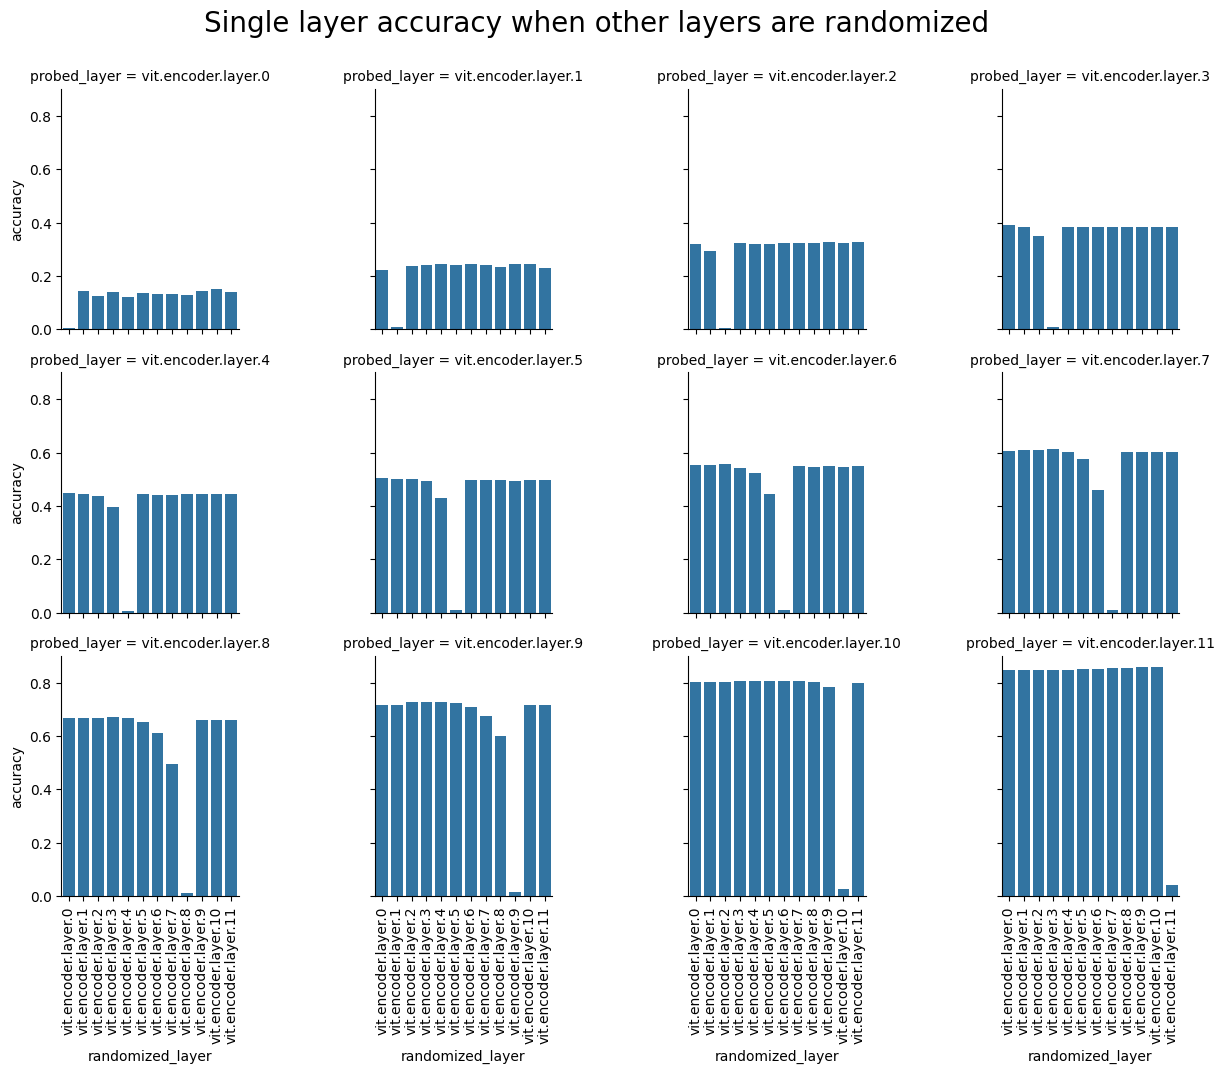

In [103]:
g = sns.FacetGrid(all_data, col="probed_layer", col_wrap=4)
g.map(sns.barplot, "randomized_layer", "accuracy", alpha=1)
g.add_legend()
_=[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
_=plt.suptitle('Single layer accuracy when other layers are randomized',  y=1.05, fontsize=20)

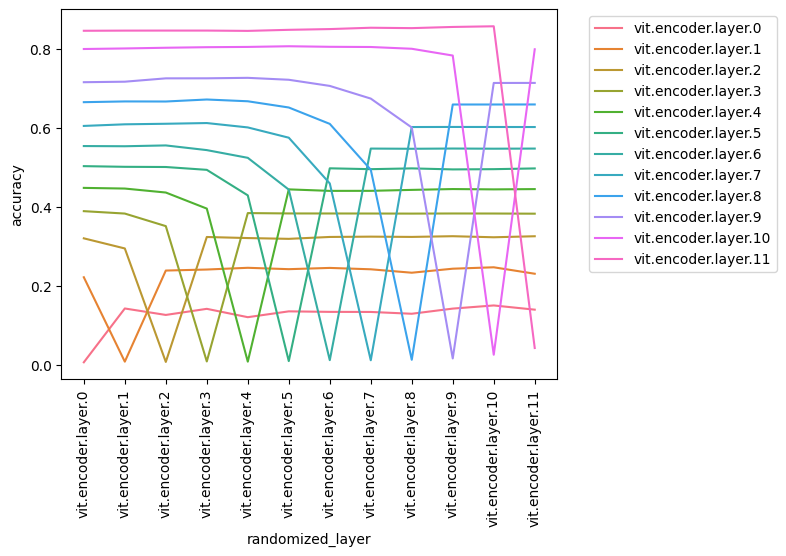

In [106]:
sns.lineplot(all_data, x='randomized_layer', y='accuracy', hue='probed_layer')
plt.legend(bbox_to_anchor=(1.05, 1))
_=plt.xticks(rotation=90)

This shows the degree of performance loss as the randomized layer gets closer to read-out layer. Interestingly, this additional loss seems to peak in the middle layers of the network, but is less severe in early and late stages.

This suggests that the middle layers are doing more 'accumulation' into the class tokens, while later layers are only performing class token 'read-out'.

Randomizing every layer will result in performance losses, unless we perform multiple runs.

In [116]:
# baseline model for comparison
from initialization import setup_model_ds_collator_images
model, dataset, _ = setup_model_ds_collator_images('google/vit-base-patch16-224', 'zh-plus/tiny-imagenet')
from training import fit_probes_by_ridge_regression

model = fit_probes_by_ridge_regression(model, dataset['train'], collator,
                                           num_train_points=200 * model.num_labels)

from analysis import model_accuracy
acc_unrandomized = model_accuracy(model, dataset['valid'])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([200, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
processing data for probe fit: 626it [03:32,  2.94it/s]                                                     
100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:01<00:00,  1.28it/s]


(0.8, 0.9)

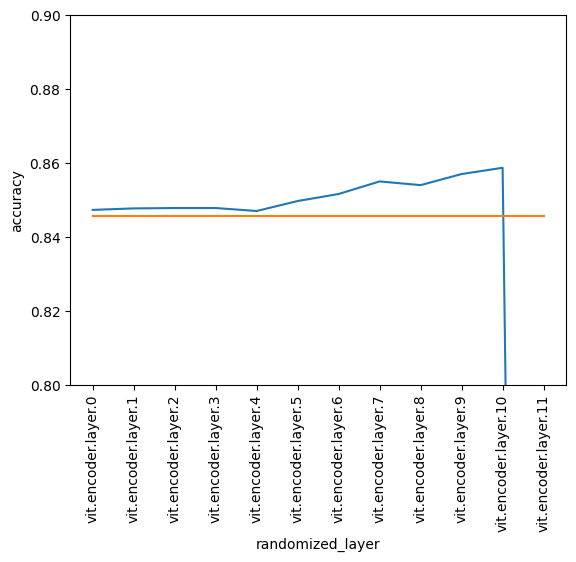

In [117]:
sns.lineplot(all_data[all_data['probed_layer'] == 'vit.encoder.layer.11'], x='randomized_layer', y='accuracy')

x_vals = all_data[all_data['probed_layer'] == 'vit.encoder.layer.11']['randomized_layer']
plt.plot(x_vals, 12*[acc_unrandomized])

_=plt.xticks(rotation=90)
plt.ylim([0.8, 0.9])

In the last layer, there appears to be a slight _increase_ from previous layer randomization and relative to the unrandomized baseline

Could be: random, similar source as the baseline accuracy increase in this layer, due to lucky 'mixing' of multiple items from the same class, real: forcing the model to ignore previously accumulated information in the CLS token.

This may dovetail with my previous observations that within-batch CLS token shuffling causes _increased_ accuracy (presumably due to information sharing). Additionally, any within-batch leakage could help explain the difference between normal randomization and shuffling randomization.

Moving forward probably requires trained random CLS token generators.